In [1]:
!whoami

llinfeng


In [2]:
# Enable automatic reloading of modules (useful during development)
%load_ext autoreload
%autoreload 2

# One-Shot Forecast Replication

This notebook provides a clean, minimal interface for running LEAR and DNN forecasts using the `forecast_pipeline` module.

It replicates the functionality from `Notebooks/02_forecasting_oneshot.ipynb` but uses the modular pipeline script for better maintainability and extensibility.

## Configuration

Set the minimal input parameters: market, start date, and number of days to predict.

For single day: set `N_DAYS = 1`
For a week: set `N_DAYS = 7`
Each day will be recalibrated independently.


In [3]:
# Minimal input configuration
MARKET = 'BE' # Full set: "PJM", "NP", "FR", "BE", "DE"
TARGET_START_DATE = '2016-12-27'  # Start date for predictions
N_DAYS = 2  # Number of consecutive days to forecast (1 = single day, 7 = week, etc.)

## Setup

Import the forecast pipeline module and set up paths.


In [4]:

import sys
from pathlib import Path

# Add src to path
# Handle both cases: running from project root or from Notebooks/
current_dir = Path.cwd()
if current_dir.name == 'Notebooks':
    project_root = current_dir.parent
else:
    project_root = current_dir

src_path = project_root / 'src'
sys.path.insert(0, str(src_path))

from forecast_pipeline import (
    load_data_from_epftoolbox,
    load_data_from_csv,
    get_actual_values,
    run_lear_forecasts,
    run_lear_forecast_multiday,
    run_dnn_hyperparameter_optimization,
    run_dnn_forecast,
    run_dnn_forecast_multiday,
    evaluate_all_models,
    save_predictions,
    load_published_benchmarks
)

import pandas as pd
import numpy as np


2025-12-15 21:54:31.459197: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-15 21:54:31.482331: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-15 21:54:31.482353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-15 21:54:31.482945: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-15 21:54:31.486746: I tensorflow/core/platform/cpu_feature_guar

## Data Loading

Load training/test data and extract actual values for the target date.


In [5]:
# Load data using epftoolbox (official train/test split)
df_train, df_test = load_data_from_epftoolbox(
    dataset=MARKET,
    years_test=2,
    path='datasets'
)

# Also load from CSV for extracting actual values
df_csv = load_data_from_csv(
    csv_path='datasets/hourly_data_all_markets.csv',
    market=MARKET
)

# Get actual values for all target days
import pandas as pd
target_start = pd.to_datetime(TARGET_START_DATE)
actual_values_dict = {}
for day_idx in range(N_DAYS):
    current_date = target_start + pd.Timedelta(days=day_idx)
    actual_values_dict[current_date.strftime('%Y-%m-%d')] = get_actual_values(df_csv, current_date)

print(f"Loaded data for {MARKET}")
print(f"Training data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")
print(f"Forecasting {N_DAYS} day(s) starting from {TARGET_START_DATE}")
for date_str, values in actual_values_dict.items():
    print(f"  {date_str}: {len(values)} hours")


Loaded data for BE
Training data shape: (34944, 3)
Test data shape: (17472, 3)
Forecasting 2 day(s) starting from 2016-12-27
  2016-12-27: 24 hours
  2016-12-28: 24 hours


## LEAR Forecasts

Run LEAR forecasts with multiple calibration windows.


In [6]:
# Define calibration windows to test
calibration_windows = [1456, 1092, 84, 56]

# Run LEAR forecasts (handles both single day and multi-day)
if N_DAYS == 1:
    # Single day - use original function
    target_date = pd.to_datetime(TARGET_START_DATE)
    lear_results_dict = run_lear_forecasts(
        df_train=df_train,
        df_test=df_test,
        target_date=target_date,
        calibration_windows=calibration_windows,
        alpha_fixed=None  # Use AIC/LARS with automatic fallback to fixed alpha
    )
    # Convert to same format as multi-day for consistency
    lear_results_multiday = {target_date.strftime('%Y-%m-%d'): lear_results_dict}
else:
    # Multi-day - use multi-day function
    lear_results_multiday = run_lear_forecast_multiday(
        df_train=df_train,
        df_test=df_test,
        target_start_date=TARGET_START_DATE,
        n_days=N_DAYS,
        calibration_windows=calibration_windows,
        alpha_fixed=None,
        verbose=True
    )

# Extract predictions for easier access (flatten structure for single day case)
if N_DAYS == 1:
    date_str = list(lear_results_multiday.keys())[0]
    lear_predictions = {
        model_name: pred for model_name, (pred, metadata) in lear_results_multiday[date_str].items()
    }
else:
    # For multi-day, keep structure organized by date
    lear_predictions = {}
    for date_str, day_results in lear_results_multiday.items():
        for model_name, (pred, metadata) in day_results.items():
            key = f"{date_str}_{model_name}"
            lear_predictions[key] = pred



######################################################################
LEAR Multi-Day Forecast Processing
Start Date: 2016-12-27
Number of Days: 2
Calibration Windows: [1456, 1092, 84, 56]
######################################################################


Day 1/2: 2016-12-27

######################################################################
LEAR Forecast Batch Processing
Total calibration windows: 4
Windows: [1456, 1092, 84, 56]
######################################################################

[1/4] Processing calibration window: 1456 days

Running LEAR forecast - Calibration Window: 1456 days
Target Date: 2016-12-27
Attempting AIC/LARS mode...
✓ AIC/LARS mode successful
✓ Completed in 8.73 seconds
  Mode: AIC, Alpha: None

[2/4] Processing calibration window: 1092 days

Running LEAR forecast - Calibration Window: 1092 days
Target Date: 2016-12-27
Attempting AIC/LARS mode...
✓ AIC/LARS mode successful
✓ Completed in 7.44 seconds
  Mode: AIC, Alpha: None

[3/4] Process

## DNN Forecasts

Run DNN hyperparameter optimization and then generate forecasts.


In [7]:
# DNN configuration
EXPERIMENT_ID = 'oneshot_dnn'
CALIBRATION_WINDOW = 4  # years
NLAYERS = 3
SHUFFLE_TRAIN = True
DATA_AUGMENTATION = True
MAX_EVALS = 20  # Maximum hyperparameter search iterations
# Note: max_evals=50 is a compromise; raise if you want more exploration.
# For shorter calibration windows (e.g., 1 year), fewer iterations may be sufficient.

# Early stopping configuration
# Stop if test MAE doesn't improve for N batches (set to None to disable)
EARLY_STOPPING_PATIENCE = 1  # Stop after 1 batch without improvement
BATCH_SIZE = 2  # Evaluations per batch when using early stopping

# Run hyperparameter optimization
trials_path = run_dnn_hyperparameter_optimization(
    dataset=MARKET,
    years_test=2,
    calibration_window=CALIBRATION_WINDOW,
    nlayers=NLAYERS,
    shuffle_train=SHUFFLE_TRAIN,
    data_augmentation=DATA_AUGMENTATION,
    max_evals=MAX_EVALS,
    experiment_id=EXPERIMENT_ID,
    path_datasets_folder='datasets',
    path_hyperparameters_folder='experimental_files',
    force_rerun=False,  # Set to True to force rerun even if trials exist
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    batch_size=BATCH_SIZE
)


Trials file already exists, skipping hyperparameter search:
experimental_files/DNN_hyperparameters_nl3_datBE_YT2_SF_DA_CW4_oneshot_dnn


In [8]:
# Run DNN forecast (handles both single day and multi-day)
if N_DAYS == 1:
    # Single day
    target_date = pd.to_datetime(TARGET_START_DATE)
    forecast_dnn = run_dnn_forecast(
        experiment_id=EXPERIMENT_ID,
        target_date=target_date,
        path_datasets_folder='datasets',
        path_hyperparameter_folder='experimental_files',
        path_recalibration_folder='predictions',
        dataset=MARKET,
        years_test=2,
        new_recalibration=True,
        nlayers=NLAYERS,
        shuffle_train=SHUFFLE_TRAIN,
        data_augmentation=DATA_AUGMENTATION,
        calibration_window=CALIBRATION_WINDOW,
    )
    dnn_predictions = {
        'DNN_4years': forecast_dnn.iloc[0].values
    }
    print(f"DNN forecast completed for {target_date.date()}")
    print(f"Prediction shape: {forecast_dnn.iloc[0].values.shape}")
else:
    # Multi-day
    dnn_forecasts_multiday = run_dnn_forecast_multiday(
        experiment_id=EXPERIMENT_ID,
        target_start_date=TARGET_START_DATE,
        n_days=N_DAYS,
        path_datasets_folder='datasets',
        path_hyperparameter_folder='experimental_files',
        path_recalibration_folder='predictions',
        dataset=MARKET,
        years_test=2,
        verbose=True,
        new_recalibration=True,
        nlayers=NLAYERS,
        shuffle_train=SHUFFLE_TRAIN,
        data_augmentation=DATA_AUGMENTATION,
        calibration_window=CALIBRATION_WINDOW,
    )
    # Flatten structure for easier access
    dnn_predictions = {}
    for date_str, forecast_df in dnn_forecasts_multiday.items():
        dnn_predictions[f"{date_str}_DNN_4years"] = forecast_df.iloc[0].values



######################################################################
DNN Multi-Day Forecast Processing
Start Date: 2016-12-27
Number of Days: 2
######################################################################


Day 1/2: 2016-12-27
Test datasets: 2016-12-27 00:00:00 - 2016-12-27 23:00:00


2025-12-15 21:55:08.145503: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-15 21:55:08.167617: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-15 21:55:08.170493: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2016-12-27 - sMAPE: 23.51%  |  MAE: 11.197
✓ Completed forecast for 2016-12-27

Day 2/2: 2016-12-28
Test datasets: 2016-12-28 00:00:00 - 2016-12-28 23:00:00


2016-12-28 - sMAPE: 24.50%  |  MAE: 11.606
✓ Completed forecast for 2016-12-28

######################################################################
Multi-Day DNN Forecast Complete
Total days processed: 2
######################################################################



## Combine All Predictions

Collect all model predictions for evaluation and saving.


In [9]:
# Create actual_values list from actual_values_dict
# For single day: just the array
# For multi-day: concatenate all days' values in order
if N_DAYS == 1:
    date_str = list(actual_values_dict.keys())[0]
    actual_values = actual_values_dict[date_str]
else:
    # Concatenate all days' actual values in chronological order
    target_start = pd.to_datetime(TARGET_START_DATE)
    actual_values = []
    for day_idx in range(N_DAYS):
        current_date = target_start + pd.Timedelta(days=day_idx)
        date_str = current_date.strftime('%Y-%m-%d')
        if date_str in actual_values_dict:
            actual_values.extend(actual_values_dict[date_str])
        else:
            print(f"Warning: No actual values found for {date_str}")
    actual_values = np.array(actual_values)

print(f"Created actual_values: {len(actual_values)} hours total")
if N_DAYS > 1:
    print(f"  ({N_DAYS} days × 24 hours = {N_DAYS * 24} hours)")

Created actual_values: 48 hours total
  (2 days × 24 hours = 48 hours)


In [10]:
# Combine all predictions
all_predictions = {**lear_predictions, **dnn_predictions}

# Add actual values for comparison
all_predictions['actual'] = actual_values

print(f"Total models: {len(all_predictions)}")
print(f"Models: {list(all_predictions.keys())}")


Total models: 11
Models: ['2016-12-27_LEAR_1456', '2016-12-27_LEAR_1092', '2016-12-27_LEAR_84', '2016-12-27_LEAR_56', '2016-12-28_LEAR_1456', '2016-12-28_LEAR_1092', '2016-12-28_LEAR_84', '2016-12-28_LEAR_56', '2016-12-27_DNN_4years', '2016-12-28_DNN_4years', 'actual']


## Evaluation Metrics

Calculate accuracy metrics for all models.


In [11]:
# Calculate metrics (exclude 'actual' from evaluation)
model_predictions = {k: v for k, v in all_predictions.items() if k != 'actual'}

# For multi-day, we need to handle evaluation differently
# For now, evaluate for single day or concatenated multi-day
target_date = pd.to_datetime(TARGET_START_DATE)

metrics_df = evaluate_all_models(
    actual=actual_values,
    predictions_dict=model_predictions,
    df_train=df_train,
    target_date=target_date  # Use start date for datetime index
)

if N_DAYS == 1:
    print(f"Accuracy Metrics for {TARGET_START_DATE}")
else:
    print(f"Accuracy Metrics for {N_DAYS} days starting from {TARGET_START_DATE}")
print("=" * 70)
print(metrics_df.round(4))
print("\nNote: MAPE and sMAPE are shown as percentages.")
print("MASE and rMAE values < 1 indicate better performance than naive forecast.")


Accuracy Metrics for 2 days starting from 2016-12-27
                MAE     RMSE  MAPE (%)  sMAPE (%)    MASE    rMAE
LEAR_1456    5.0135   6.5088   10.5111    10.3923  0.6372  1.0088
LEAR_1092    5.0145   6.7617   10.1617    10.5082  0.6374  1.0090
LEAR_84      9.4292  11.1954   20.1410    17.9617  1.1985  1.8974
LEAR_56     10.3037  14.1677   22.7929    19.0542  1.3097  2.0734
DNN_4years  11.4018  14.0436   21.7377    24.0049  1.4492  2.2943

Note: MAPE and sMAPE are shown as percentages.
MASE and rMAE values < 1 indicate better performance than naive forecast.


## Save Predictions

Save all predictions to CSV file in the `predictions/` folder.


In [12]:
# Save predictions (including actual for reference)
target_date = pd.to_datetime(TARGET_START_DATE)
if N_DAYS == 1:
    filename = f'predictions_{MARKET}_{TARGET_START_DATE.replace("-", "")}.csv'
else:
    # For multi-day, include end date in filename
    end_date = (target_date + pd.Timedelta(days=N_DAYS-1)).strftime('%Y%m%d')
    filename = f'predictions_{MARKET}_{TARGET_START_DATE.replace("-", "")}_to_{end_date}.csv'

save_predictions(
    predictions_dict=all_predictions,
    target_date=target_date,
    output_path='predictions',
    filename=filename
)


Saved predictions to: predictions/predictions_BE_20161227_to_20161228.csv


PosixPath('predictions/predictions_BE_20161227_to_20161228.csv')

## Optional: Compare with Published Benchmarks

Load and compare with published benchmark forecasts if available.


In [13]:
# Load published benchmarks (optional - only if benchmark file exists)
# For multi-day forecasts, we concatenate one-day benchmarks over the full
# target horizon so they match the prediction duration.
if N_DAYS == 1:
    try:
        published_benchmarks = load_published_benchmarks(
            csv_path='forecasts/Forecasts_PJM_DNN_LEAR_ensembles.csv',
            target_date=TARGET_START_DATE,
            model_columns=['LEAR 56', 'LEAR 84', 'LEAR 1092', 'LEAR 1456', 'DNN 1', 'DNN 2', 'DNN 3', 'DNN 4']
        )
        
        print("Published benchmarks loaded:")
        for model_name, values in published_benchmarks.items():
            print(f"  {model_name}: {len(values)} values")
            
    except FileNotFoundError:
        print("Published benchmark file not found. Skipping comparison.")
        published_benchmarks = None
else:
    try:
        target_start = pd.to_datetime(TARGET_START_DATE)
        published_benchmarks = {}
        
        # Pull one-day benchmarks for each day in the forecast horizon and
        # concatenate them so they span the full target duration.
        for day_idx in range(N_DAYS):
            current_date = target_start + pd.Timedelta(days=day_idx)
            day_benchmarks = load_published_benchmarks(
                csv_path='forecasts/Forecasts_PJM_DNN_LEAR_ensembles.csv',
                target_date=current_date,
                model_columns=['LEAR 56', 'LEAR 84', 'LEAR 1092', 'LEAR 1456', 'DNN 1', 'DNN 2', 'DNN 3', 'DNN 4']
            )
            for model_name, values in day_benchmarks.items():
                published_benchmarks.setdefault(model_name, []).extend(values)
        
        print(f"Published benchmarks loaded for {N_DAYS} day(s) starting from {TARGET_START_DATE}:")
        for model_name, values in published_benchmarks.items():
            print(f"  {model_name}: {len(values)} values")
    except FileNotFoundError:
        print("Published benchmark file not found. Skipping comparison.")
        published_benchmarks = None


Published benchmarks loaded for 2 day(s) starting from 2016-12-27:
  LEAR 56: 48 values
  LEAR 84: 48 values
  LEAR 1092: 48 values
  LEAR 1456: 48 values
  DNN 1: 48 values
  DNN 2: 48 values
  DNN 3: 48 values
  DNN 4: 48 values


## Visualization

Plot predictions vs actual values for visual comparison.


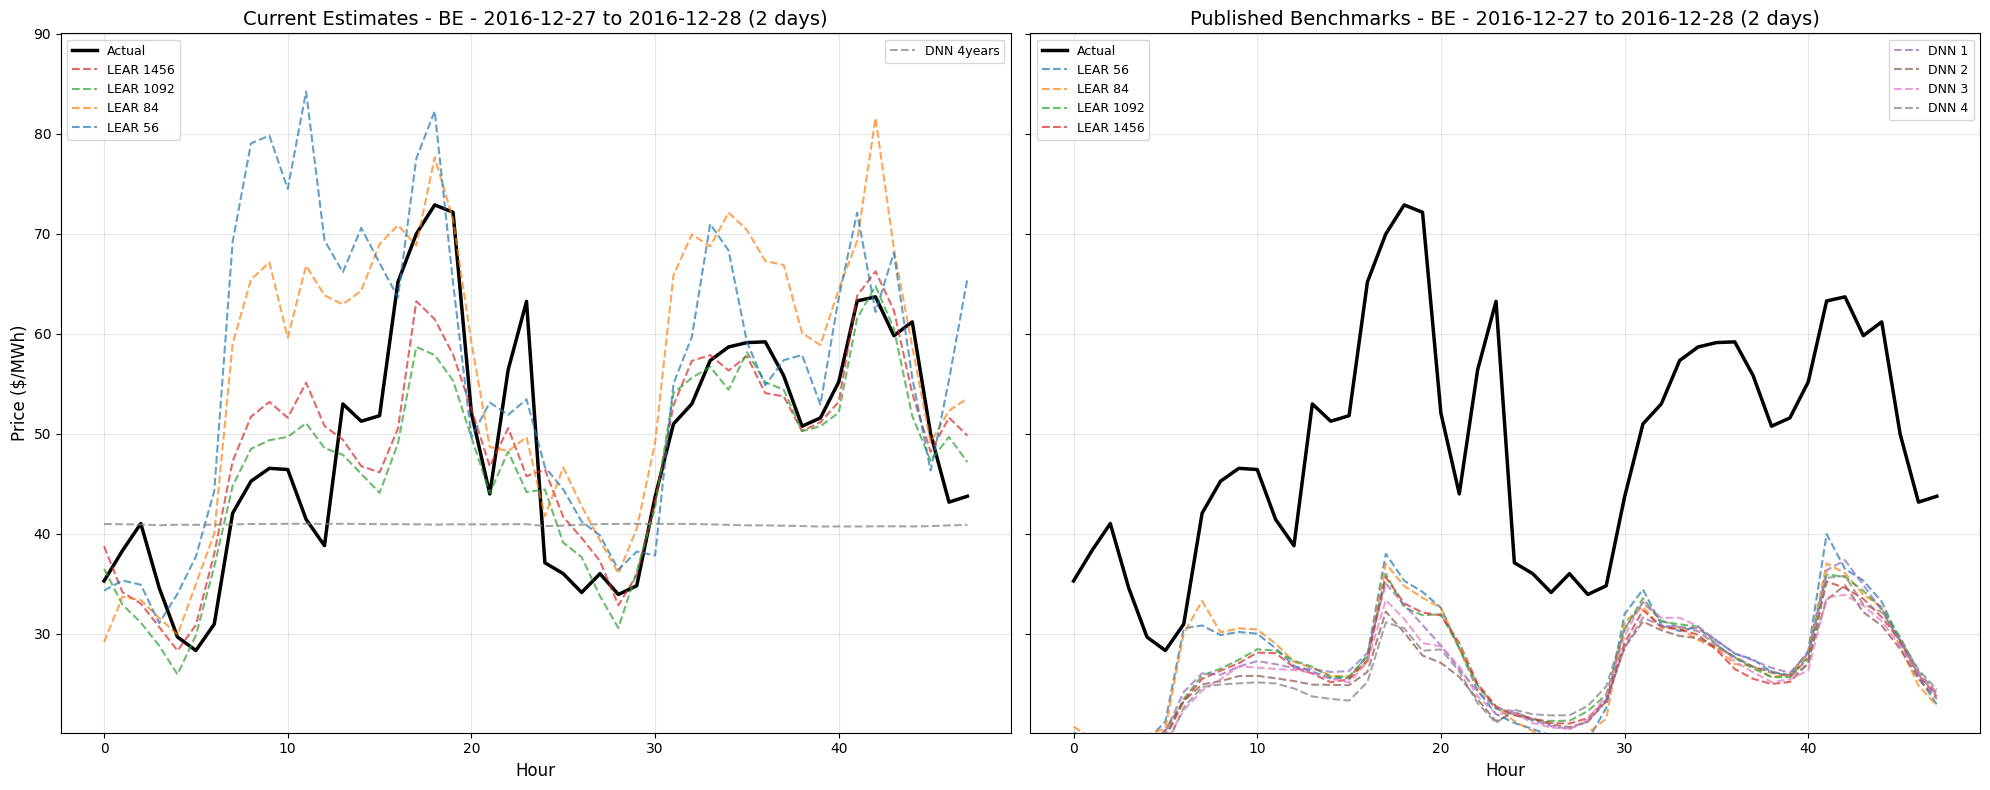

In [14]:
import matplotlib.pyplot as plt
import re

# Prepare predictions for plotting: aggregate multi-day model keys
# like "YYYY-MM-DD_LEAR_1456" into a single series per base model
# so that all columns have the same length as 'actual'.
plot_date_pattern = re.compile(r"^(\d{4}-\d{2}-\d{2})_(.+)$")

grouped_plot = {}
passthrough_plot = {}

for key, values in all_predictions.items():
    arr = np.asarray(values).flatten()
    m = plot_date_pattern.match(key)
    if m:
        date_str, base_name = m.groups()
        ts = pd.to_datetime(date_str)
        grouped_plot.setdefault(base_name, []).append((ts, arr))
    else:
        passthrough_plot[key] = arr

processed_plot = dict(passthrough_plot)
for base_name, items in grouped_plot.items():
    items_sorted = sorted(items, key=lambda x: x[0])
    concatenated = np.concatenate([a for _, a in items_sorted])
    processed_plot[base_name] = concatenated

# Align all series to the same length for plotting
if 'actual' in processed_plot:
    target_len_plot = len(processed_plot['actual'])
elif processed_plot:
    target_len_plot = len(next(iter(processed_plot.values())))
else:
    target_len_plot = 0

aligned_predictions = {}
for name, arr in processed_plot.items():
    if target_len_plot and len(arr) != target_len_plot:
        print(f"Warning: skipping {name} in plot; length {len(arr)} != {target_len_plot}")
        continue
    aligned_predictions[name] = arr

# Create dataframe for plotting
df_plot = pd.DataFrame(aligned_predictions)

# Determine y-axis range from current predictions (to reuse scale)
y_min = df_plot.min().min() if len(df_plot) > 0 else 0
y_max = df_plot.max().max() if len(df_plot) > 0 else 50
y_padding = (y_max - y_min) * 0.1  # 10% padding
y_range = [y_min - y_padding, y_max + y_padding]

# Define color mapping for LEAR models based on calibration window
# Extract window number from model name and assign consistent colors
def get_lear_window(model_name):
    """Extract calibration window number from LEAR model name."""
    # Match patterns like "LEAR_56", "LEAR 56", "LEAR_1456", etc.
    match = re.search(r'LEAR[_\s](\d+)', model_name)
    if match:
        return int(match.group(1))
    return None

# Color palette for LEAR windows (distinct colors)
lear_colors = {
    56: '#1f77b4',    # blue
    84: '#ff7f0e',    # orange
    1092: '#2ca02c',  # green
    1456: '#d62728',  # red
}

# Color palette for DNN models
dnn_colors = ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f']  # purple, brown, pink, gray

def get_model_color(model_name):
    """Get color for a model based on its type and calibration window."""
    lear_window = get_lear_window(model_name)
    if lear_window and lear_window in lear_colors:
        return lear_colors[lear_window]
    
    # DNN models - use cycling colors
    if 'DNN' in model_name:
        dnn_num_match = re.search(r'DNN[_\s](\d+)', model_name)
        if dnn_num_match:
            dnn_num = int(dnn_num_match.group(1))
            return dnn_colors[(dnn_num - 1) % len(dnn_colors)]
        return dnn_colors[0]
    
    # Default color for other models
    return '#17becf'  # cyan

# Helper to build title text over the full target duration
if N_DAYS == 1:
    title_suffix = f"{TARGET_START_DATE}"
else:
    end_date = (pd.to_datetime(TARGET_START_DATE) + pd.Timedelta(days=N_DAYS-1)).strftime('%Y-%m-%d')
    title_suffix = f"{TARGET_START_DATE} to {end_date} ({N_DAYS} days)"

# Create figure with subplots when benchmarks are available
if published_benchmarks is not None:
    # Two plots: current estimates and published benchmarks over the full horizon
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    
    # Plot 1: Current estimates
    if 'actual' in df_plot.columns:
        ax1.plot(df_plot['actual'], label='Actual', linestyle='-', linewidth=2.5, color='black')
    
    # Plot current model predictions with consistent colors
    for column in df_plot.columns:
        if column != 'actual':
            color = get_model_color(column)
            ax1.plot(df_plot[column], label=column.replace('_', ' '), 
                    linestyle='--', alpha=0.7, linewidth=1.5, color=color)
    
    ax1.set_xlabel("Hour", fontsize=12)
    ax1.set_ylabel("Price ($/MWh)", fontsize=12)
    ax1.set_title(f"Current Estimates - {MARKET} - {title_suffix}", fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(y_range)

    # Legends: split LEAR vs DNN for clearer columns
    h1, l1 = ax1.get_legend_handles_labels()
    lear_handles, lear_labels, dnn_handles, dnn_labels, other_handles, other_labels = [], [], [], [], [], []
    for h, lbl in zip(h1, l1):
        if lbl.startswith('LEAR'):
            lear_handles.append(h); lear_labels.append(lbl)
        elif lbl.startswith('DNN'):
            dnn_handles.append(h); dnn_labels.append(lbl)
        elif lbl == 'Actual':
            other_handles.append(h); other_labels.append(lbl)
        else:
            other_handles.append(h); other_labels.append(lbl)
    # First legend: Actual + LEAR (one column)
    leg1 = ax1.legend(other_handles + lear_handles, other_labels + lear_labels,
                      loc='upper left', fontsize=9, ncol=1, frameon=True)
    ax1.add_artist(leg1)
    # Second legend: DNN (one column)
    if dnn_handles:
        ax1.legend(dnn_handles, dnn_labels, loc='upper right', fontsize=9, ncol=1, frameon=True)
    
    # Plot 2: Published benchmarks (already concatenated over horizon)
    if 'actual' in df_plot.columns:
        ax2.plot(df_plot['actual'], label='Actual', linestyle='-', linewidth=2.5, color='black')
    
    # Plot published benchmark predictions with matching colors
    for model_name, values in published_benchmarks.items():
        if len(values) == len(df_plot):
            color = get_model_color(model_name)
            ax2.plot(values, label=model_name, linestyle='--', alpha=0.7, linewidth=1.5, color=color)
    
    ax2.set_xlabel("Hour", fontsize=12)
    ax2.set_title(f"Published Benchmarks - {MARKET} - {title_suffix}", fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(y_range)  # Same y-range for comparison

    # Legends for ax2
    h2, l2 = ax2.get_legend_handles_labels()
    lear_handles2, lear_labels2, dnn_handles2, dnn_labels2, other_handles2, other_labels2 = [], [], [], [], [], []
    for h, lbl in zip(h2, l2):
        if lbl.startswith('LEAR'):
            lear_handles2.append(h); lear_labels2.append(lbl)
        elif lbl.startswith('DNN'):
            dnn_handles2.append(h); dnn_labels2.append(lbl)
        elif lbl == 'Actual':
            other_handles2.append(h); other_labels2.append(lbl)
        else:
            other_handles2.append(h); other_labels2.append(lbl)
    leg2 = ax2.legend(other_handles2 + lear_handles2, other_labels2 + lear_labels2,
                      loc='upper left', fontsize=9, ncol=1, frameon=True)
    ax2.add_artist(leg2)
    if dnn_handles2:
        ax2.legend(dnn_handles2, dnn_labels2, loc='upper right', fontsize=9, ncol=1, frameon=True)
    
    plt.tight_layout()
    plt.show()
    
else:
    # Single plot: current estimates only
    plt.figure(figsize=(14, 8))
    
    # Plot actual values with distinct style
    if 'actual' in df_plot.columns:
        plt.plot(df_plot['actual'], label='Actual', linestyle='-', linewidth=2.5, color='black')
    
    # Plot model predictions with consistent colors
    for column in df_plot.columns:
        if column != 'actual':
            color = get_model_color(column)
            plt.plot(df_plot[column], label=column.replace('_', ' '), 
                    linestyle='--', alpha=0.7, linewidth=1.5, color=color)
    
    plt.xlabel("Hour", fontsize=12)
    plt.ylabel("Price ($/MWh)", fontsize=12)
    plt.title(f"Forecast Comparison for {MARKET} - {title_suffix}", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.ylim(y_range)  # Use consistent scale

    # Legends split into LEAR vs DNN
    handles, labels = plt.gca().get_legend_handles_labels()
    lear_h, lear_l, dnn_h, dnn_l, other_h, other_l = [], [], [], [], [], []
    for h, lbl in zip(handles, labels):
        if lbl.startswith('LEAR'):
            lear_h.append(h); lear_l.append(lbl)
        elif lbl.startswith('DNN'):
            dnn_h.append(h); dnn_l.append(lbl)
        elif lbl == 'Actual':
            other_h.append(h); other_l.append(lbl)
        else:
            other_h.append(h); other_l.append(lbl)
    # Place two legends
    legA = plt.legend(other_h + lear_h, other_l + lear_l, loc='upper left', fontsize=10, ncol=1, frameon=True)
    plt.gca().add_artist(legA)
    if dnn_h:
        plt.legend(dnn_h, dnn_l, loc='upper right', fontsize=10, ncol=1, frameon=True)
    
    plt.tight_layout()
    plt.show()
